In [1]:
#fetch GFS data and plot at ENA
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import netCDF4
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from datetime import datetime, timedelta
from netCDF4 import num2date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import ftplib
import pygrib
import tempfile
import xarray
import boto3

%matplotlib inline

In [86]:
import imp
lib_loc = os.path.join(os.path.expanduser('~'), 'projects/ACE-ENA-EVA/code/ena_tools.py')
ena_tools = imp.load_source('ena_tools', lib_loc)


/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
var_list = ['Specific cloud liquid water content', 'Specific cloud ice water content',
           'Specific rain water content', 'Specific snow water content',
           'Temperature', 'V component of wind', 'U component of wind', 'Specific humidity', 'Vertical velocity']
skip_me = [False, False, False, False, False, True, True, False, False] 

In [77]:
my_bundle, my_these_valid_times, my_these_run_times, my_lats, my_lons, metad = ena_tools.create_bundle_latest(var_list,
                                                                                             skippy=skip_me,
                                                                                            n=40)


D1D06271200062712011
D1D06271200062715001
D1D06271200062718001
D1D06271200062721001
D1D06271200062800001
D1D06271200062803001
D1D06271200062806001
D1D06271200062809001
D1D06271200062812001
D1D06271200062815001
D1D06271200062818001
D1D06271200062821001
D1D06271200062900001
D1D06271200062903001
D1D06271200062906001
D1D06271200062909001
D1D06271200062912001
D1D06271200062915001
D1D06271200062918001
D1D06271200062921001
D1D06271200063000001
D1D06271200063003001
D1D06271200063006001
D1D06271200063009001
D1D06271200063012001
D1D06271200063015001
D1D06271200063018001
D1D06271200063021001
D1D06271200070100001
D1D06271200070103001
D1D06271200070106001
D1D06271200070109001
D1D06271200070112001
D1D06271200070115001
D1D06271200070118001
D1D06271200070121001
D1D06271200070200001
D1D06271200070203001
D1D06271200070206001


In [82]:
my_unwind = ena_tools.concat_bundle(my_bundle)
trans = {'cfName': 'standard_name'}
my_dataset = ena_tools.unwind_to_xarray(my_unwind, my_these_valid_times, my_lats, my_lons, metad, trans=trans)
my_dataset.attrs['Conventions'] = 'CF-1.6'
my_dataset.attrs['source'] = 'ECMWF 137 level 0.1 degree model'
my_dataset.attrs['conatact'] = 'Scott Collis, scollis@anl.gov'
st1 = "European Center for Medium range Weather Forecasting, "
st2 = "Atmospheric Climate Research Facility, A DoE User facility, "
st3 = "Scott Collis, Argonne National Laboratory"
my_dataset.attrs['attribution'] = st1 + st2 + st3
my_dataset.attrs['experiment'] ='ACE-ENA'


my_dataset.Specific_cloud_ice_water_content.attrs['standard_name'] = 'cloud_ice_mixing_ratio'
my_dataset.Specific_cloud_liquid_water_content.attrs['standard_name'] = 'cloud_liquid_water_mixing_ratio'
my_dataset.Specific_rain_water_content.attrs['standard_name'] = 'rain_water_content'
my_dataset.Specific_snow_water_content.attrs['standard_name'] = 'snow_water_content'

my_dataset.encoding['unlimited_dims'] = ['time']


my_dataset.z.encoding['_FillValue'] = -9999
my_dataset.lat.encoding['_FillValue'] = -9999
my_dataset.lon.encoding['_FillValue'] = -9999



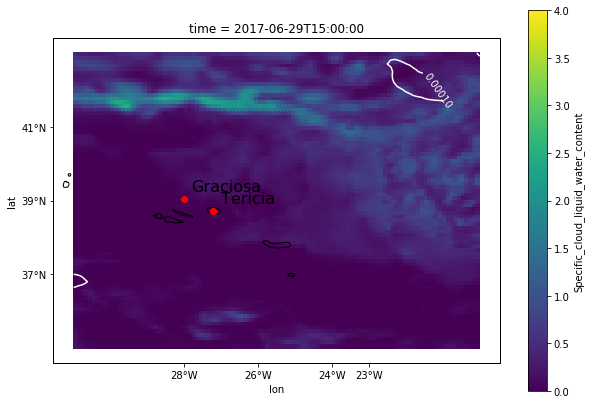

In [79]:
fig = plt.figure(figsize=[10,7])

my_ax = plt.subplot(projection = ccrs.PlateCarree())
my_levels = [0.0001, 0.05, 0.1, 1.0]
my_colors = ['white', 'yellow', 'cyan', 'pink']

pc, cs = ena_tools.ecm_tile_sum(my_ax, my_dataset.Specific_cloud_liquid_water_content*1000.0,
                      my_dataset.Specific_cloud_ice_water_content*1000.0, 
                      [0.0, 4.0], 17, my_levels, my_colors, fmt='%0.5f')

In [75]:
def nine_panel_ecm_sum(var1, var2, vlims, tsteps, levels, colors, fmt='%0.5f'):
    f, ((ax1, ax2, ax3),
        (ax4, ax5, ax6),
        (ax7, ax8, ax9)) = plt.subplots(3,3, figsize = [20,15],
                                        subplot_kw={'projection': ccrs.PlateCarree()})

    axxx = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
    for i in range(len(axxx)):
        _,_ = ena_tools.ecm_tile_sum(axxx[i], var1, var2, vlims, tsteps[i], levels, colors, fmt='%0.5f')


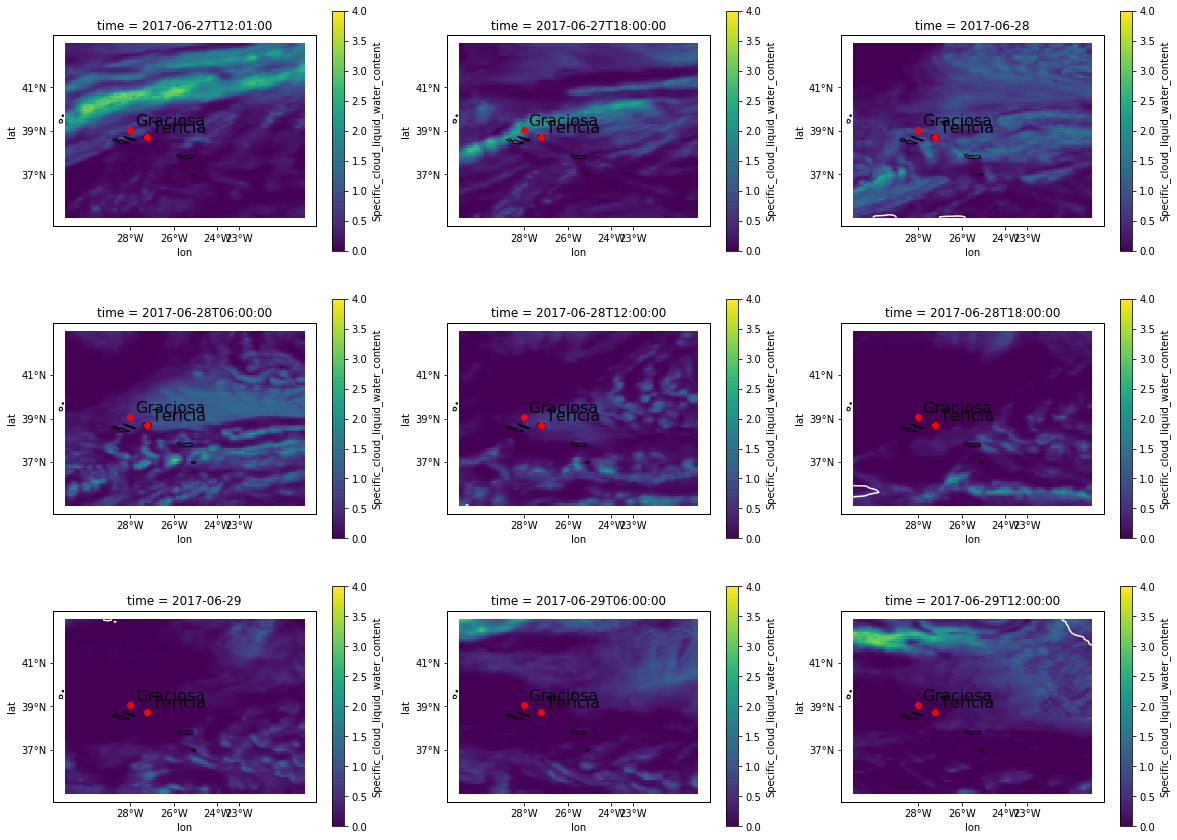

In [78]:

my_levels = [0.0001, 0.05, 0.1, 1.0]
my_colors = ['white', 'yellow', 'cyan', 'pink']

nine_panel_ecm_sum(my_dataset.Specific_cloud_liquid_water_content*1000.0,
                      my_dataset.Specific_cloud_ice_water_content*1000.0, 
                      [0.0, 4.0], [0,2,4,6,8,10,12,14,16] , my_levels, my_colors, fmt='%0.5f')

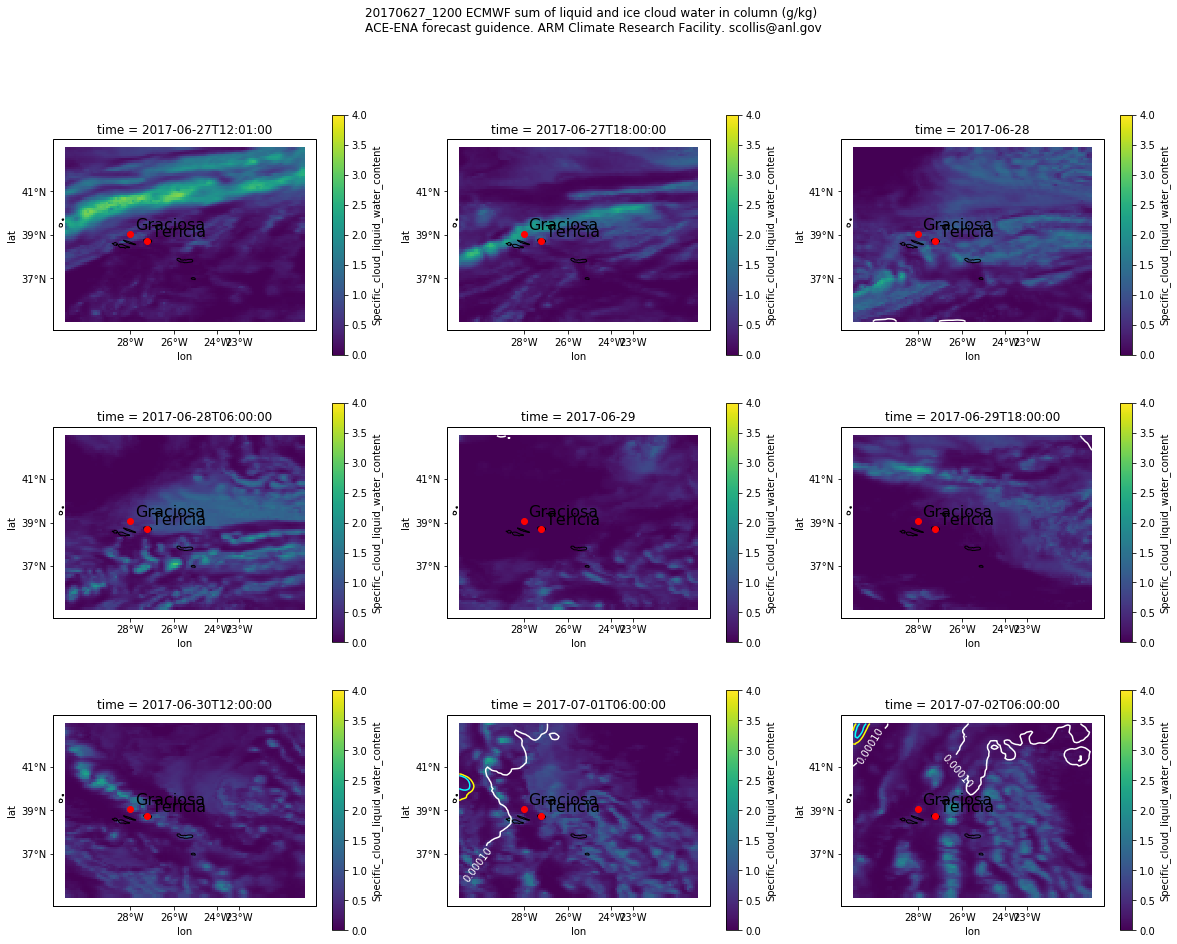

In [87]:
ena_tools.save_one_ecmwf_cloud9(my_dataset, my_these_run_times[0])
